# <span style="color:#0080FF;">Udacity - Data Analyst Nanodegree </span>
## <span style="color:#B45F04;">Project 5: Identify Fraud from Enron Email</span>
### <span style="color:black;">Created by: Layne Newhouse</span>
### <span style="color:#6E6E6E;">Submitted: December X, 2016</span>

### *Background Information*

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, we will be playing detective by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. Labels will be provided via a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. Features for the dataset include a subset of financial features as well as email features as follows:


<b>Financial Features:</b> ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

<b>Email Features:</b> ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

<b>POI Label:</b> [‘poi’] (boolean, represented as integer)

### *Project Tasks*

1. Select features
2. Identify and remove outliers
3. Create new features
4. Analyze a variety of classifiers
5. Tune a chosen classifier to achieve > 0.3 precision and recall
6. Dump the classifier, dataset and feature list

### *Getting Started*

The list below is a consolidation of the imported functions and modules that were used throughout the project. Having these imports in one place as opposed to scattered across the code makes it cleaner and easier to read. 

In [95]:
#standard modules used throughout
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import warnings
import pickle
import time
import sys
#plots display in notebook
%matplotlib inline
#import math(scipy stats), and dictionary modules
from collections import defaultdict
from scipy.stats import randint
from scipy import stats
#import course provided functions
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
#import sklearn classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#import additional sklearn modules 
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit,\
                                    RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#supresses warnings about cross_validation being depreciated in favour of
#model_selection, introduced version 0.18 removed 0.20
warnings.simplefilter(action = "ignore", category = FutureWarning)

### *Understanding the Dataset*

This section looks at important characteristics of the dataset such as total number of data points, allocation across classes (POI/non-POI), number of features used, and features with many missing values. In additional, any outliers in the dataset will be identified and removed if deemed necessary.

In [3]:
#load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    enron_data = pickle.load(data_file)

In [4]:
#total number of data points
def total_people(dataset):
    people = len(dataset)
    print "Total Number of People in the Dataset:", people
    return people
    
people = total_people(enron_data)

Total Number of People in the Dataset: 146


In [5]:
#allocation across classes (POI/non-POI)
def total_classes(dataset):
    poi = 0
    people = 0
    for person in dataset:
        people += 1
        if dataset[person]["poi"]==1:
            poi += 1
    poi_pct = 100*float(poi)/people
    print "Number of POIs in the Dataset:",poi,"(%0.2f%%)"%poi_pct
    print "Number of Non-POIs in the Dataset:",people-poi,\
                                                "(%0.2f%%)"%(100-poi_pct)
    return poi

poi = total_classes(enron_data)

Number of POIs in the Dataset: 18 (12.33%)
Number of Non-POIs in the Dataset: 128 (87.67%)


By analyzing the data with the snippets of code above, we can start to understand what our dataset looks like and what each of the of the features have to offer in terms of the number and percentage of datapoints (or people) with missing values for each individual feature.

Before removing any 'bad data' or outliers from our data, we see that we have 146 data points (people) in the dataset. Of those people, 18 (12.3%) are labeled as Persons of Interest (POIs) and 128 (87.7%) are labeled as Non-POIs. With such a small dataset and a small pool of data points being classified as 'true' for being a POI we must be careful with the removal of outliers as well as the way in which we train and test our classifiers. Such precaussions would be to not remove POIs unless abosolutely needed as well as using the entire dataset to train our classifier and then validate it using a stratified shuffle as opposed to a simple test/train split. (We will go into further detail of this in the following sections).

In [6]:
#number of features used
def total_features(dataset):
    features = []
    for key, value in dataset.iteritems() :
        for item in value:
            if item not in features:
                features.append(item)
    print "Number of Features Available:", len(features)
    return features
    
features = total_features(enron_data)
print "\nList of Features:", features

Number of Features Available: 21

List of Features: ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


Missing Features [Total, POI]:
defaultdict(<type 'list'>, {'salary': [51, 1], 'to_messages': [60, 4], 'deferral_payments': [107, 13], 'total_payments': [21, 0], 'loan_advances': [142, 17], 'bonus': [64, 2], 'email_address': [35, 0], 'restricted_stock_deferred': [128, 18], 'total_stock_value': [20, 0], 'shared_receipt_with_poi': [60, 4], 'long_term_incentive': [80, 6], 'exercised_stock_options': [44, 6], 'from_messages': [60, 4], 'other': [53, 0], 'from_poi_to_this_person': [60, 4], 'from_this_person_to_poi': [60, 4], 'poi': [0, 0], 'deferred_income': [97, 7], 'expenses': [51, 0], 'restricted_stock': [36, 1], 'director_fees': [129, 18]})

Missing Features as a Percentile [Total %, POI %]:
defaultdict(<type 'list'>, {'salary': ['34.9', '5.6'], 'to_messages': ['41.1', '22.2'], 'deferral_payments': ['73.3', '72.2'], 'total_payments': ['14.4', '0.0'], 'loan_advances': ['97.3', '94.4'], 'bonus': ['43.8', '11.1'], 'email_address': ['24.0', '0.0'], 'restricted_stock_deferred': ['87.7', '100.0'

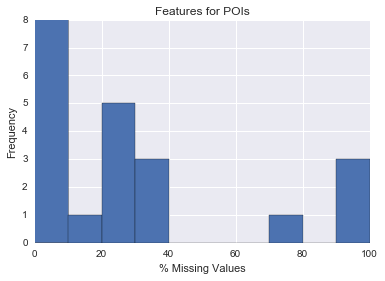

In [7]:
#indentifying features with missing values
missing_features = defaultdict(list)
mf_percent = defaultdict(list)
mf_poi = []
for feature in features:
    missing_features[feature] = [0,0]
    mf_percent[feature] = [0,0]
    
for person in enron_data:
    for feature in features:
        if enron_data[person][feature] == 'NaN':
            missing_features[feature][0] += 1
            if enron_data[person]["poi"] == 1:
                missing_features[feature][1] += 1
                
for feature in missing_features:
    x = (100*missing_features[feature][0] / float(people))
    mf_percent[feature][0] = "%0.1f" % x
    y = (100*missing_features[feature][1] / float(poi))
    mf_percent[feature][1] = "%0.1f" % y
    mf_poi.append(y)
    
print "Missing Features [Total, POI]:\n", missing_features
print "\nMissing Features as a Percentile [Total %, POI %]:\n", mf_percent

plt.hist(mf_poi)
plt.title("Features for POIs")
plt.xlabel("% Missing Values")
plt.ylabel("Frequency")
plt.show()

As seen from above, there are 21 features avaialbe in the dataset, one of them being the POI label. By printing out the labels we can verify that they are indeed legitimate labels (in terms of the strings themselves). Next we tallied the number of 'NaN's in each label and compared them against the POI allocations. Here we observe that there are a number of features that have a significant amount of missing values for POIs. By creating a quick plot we can see that there are a group of three features with over 90% of the POIs missing values for and one feature with over 70% of the POIs missing values for. Since we only have 18 POIs to begin with, features in which many POI's don't have values for will not provide a lot of information on how to identify the POIs and will likely confuse our classifiers since any NaN's will be later converted into zeros. Therefore the following features will be removed from the analysis:

In [8]:
#removing features
removed_features = []
for feature in mf_percent:
    if float(mf_percent[feature][1]) > 70:
        removed_features.append(feature)
for person in enron_data:
    for feature in removed_features:
        enron_data[person].pop(feature, 0)
print "Removed Features:\n", removed_features

Removed Features:
['deferral_payments', 'loan_advances', 'restricted_stock_deferred', 'director_fees']


Next we will do a similar missing value analysis but this time on the data points instead of the features. This will allow us to identify any people that aren't providing a significant amount of information and then choose whether or not we would like to exclude them from the dataset.

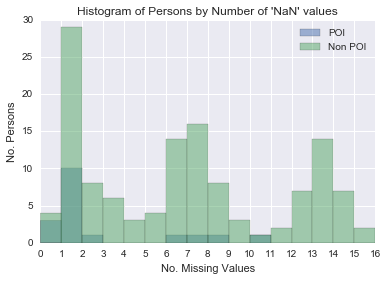

In [9]:
#indentifying persons with missing values
names = []
zeros = []
pois = []
for person in enron_data:
    zero = 0
    pois.append(enron_data[person]['poi'])
    for key in enron_data[person]:
        value = enron_data[person][key]
        if value == (0 or 'NaN'):
            zero += 1
    names.append(person)
    zeros.append(zero)
#seperating zeros with POI allocation
poi_true = []
poi_false = []
for i in range(0, len(zeros)):
    if pois[i] == True:
        poi_true.append(zeros[i])
    else:
        poi_false.append(zeros[i])
#histogram of persons by number of NaN values, seperated by POI allocation
binwidth = 1
bins= range(min(poi_false), max(poi_false) + binwidth, binwidth)
plt.hist(poi_true, bins, alpha=0.5, label='POI')
plt.hist(poi_false, bins, alpha=0.5, label='Non POI')
plt.legend(loc='upper right')
plt.xticks(np.arange(min(poi_false), max(poi_false)+1, 1.0))
plt.title('Histogram of Persons by Number of \'NaN\' values')
plt.xlabel("No. Missing Values")
plt.ylabel("No. Persons")
plt.show()

The problem, as stated above, with having too many NaNs they will eventually all converted into zeros and then processed by the classifiers. Thus if there was a large group of people that were all classified as Non POI and had many missing feature values the classifiers could wrongly associate these missing feature values, or zeros, as being a trait of Non-POIs.

The visualization above shows us the amount of people that have x features missing from the total feature set, x being denoted on the x-axis. Since we do not want to remove any POIs from the dataset, we will remove all datapoints that have 11 or more missing feature values.

In [10]:
removed_names = []
for i in range(0, len(names)):
    if zeros[i] >= 11:
        enron_data.pop(names[i], 0)
        removed_names.append(names[i])

print "No. Datapoints Removed:", len(removed_names), "\n\n", removed_names

No. Datapoints Removed: 32 

['LOWRY CHARLES P', 'WALTERS GARETH W', 'CHAN RONNIE', 'BELFER ROBERT', 'WODRASKA JOHN', 'URQUHART JOHN A', 'WHALEY DAVID A', 'MENDELSOHN JOHN', 'CLINE KENNETH W', 'WAKEHAM JOHN', 'DUNCAN JOHN H', 'LEMAISTRE CHARLES', 'WROBEL BRUCE', 'MEYER JEROME J', 'SCRIMSHAW MATTHEW', 'GATHMANN WILLIAM D', 'GILLIS JOHN', 'LOCKHART EUGENE E', 'PEREIRA PAULO V. FERRAZ', 'BLAKE JR. NORMAN P', 'PRENTICE JAMES', 'GRAY RODNEY', 'THE TRAVEL AGENCY IN THE PARK', 'NOLES JAMES L', 'CHRISTODOULOU DIOMEDES', 'JAEDICKE ROBERT', 'WINOKUR JR. HERBERT S', 'BADUM JAMES P', 'YEAP SOON', 'FUGH JOHN L', 'SAVAGE FRANK', 'GRAMM WENDY L']


After printing and reading the removed datapoints I had noticed that "THE TRAVEL AGENCY IN THE PARK" had made it into the dataset. When looking back at the insider pay pdf, I could confirm that this point existed and was located at the very end of the document. Depending on the size and type of dataset, different measures could be taken to identify dirty data including a character search, word count or looking at the number of legitamate feature values as we did above.

Now that we have removed datapoints without insignificant feature values, we will take a look at datapoints with feature values that are too high, i.e. outliers. Plotting variables against eachother will allow us to visually detect any abnormalities within the data. I will arbitrarily begin by plotting the features bonus and total_stock_value.

In [42]:
def scatter(dataset, features):
    data = featureFormat(dataset, features)
    for pair in data:
        x = pair[0]
        y = pair[1]
        plt.scatter(x,y)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()    

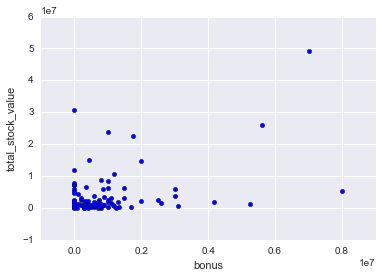

In [40]:
#plotting salary vs bonus
features = ['bonus', 'total_stock_value']#try one of the ones that points to ken
scatter_feature_pair(enron_data, features)

From this graph we can visually identify an outlier that is far beyond any other datapoint in the dataset. The next step would be to identify who or what this point actually is. 

In [18]:
#searching for the outlier
def find_largest_value(dataset, feature_name):
    outlier_name = ""
    largest_value = 0
    for key, value in enron_data.iteritems():
        inside_dict = value
        for k, v in inside_dict.iteritems():
            if (k == feature_name) & (v != 'NaN'):
                if v > largest_value:
                    largest_value = v
                    outlier_name = key
    print outlier_name, largest_value

In [19]:
find_largest_value(enron_data, 'bonus')

TOTAL 26704229


Looking back at the insider pay pdf, it is easy to see how "TOTAL" could have gotten into the dataset and is another good example of dirty data that needs to be removed. After removing "TOTAL" I will re-create the scatterplot and add histograms to each feature. 

In [49]:
enron_data.pop("TOTAL", 0);

In [46]:
def scatter_hist(dataset, features):
    data = featureFormat(enron_data, features)
    df = pd.DataFrame(data, columns=[features[0], features[1]])
    sns.jointplot(x=features[0], y=features[1], data=df)

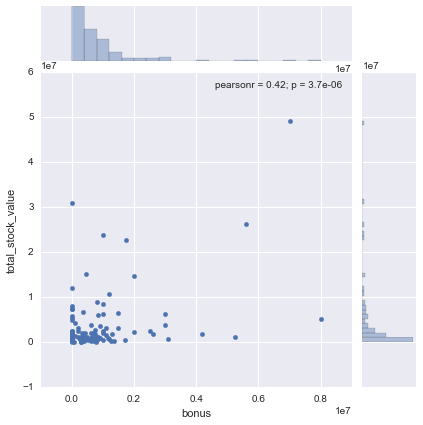

In [50]:
scatter_hist(enron_data, features)

In [54]:
find_largest_value(enron_data, 'bonus')
find_largest_value(enron_data, 'total_stock_value')

LAVORATO JOHN J 8000000
LAY KENNETH L 49110078


Having removed "TOTAL" the scatter plot starting to look better but there are still a few significant outliers that are making a lot more money than the majority. Looking at the persons with the highest bonus and total_stock_value we see that they are both legitamate names for employees and at least one of which is a POI (Kenneth Lay, CEO).

As we reduce the number of features by weeding out features with insignificant information, it is also important to add and manipulate features. In adding features we can use our own human intuition and multiply or divide certain features together if it makes sense to do so. Later on in this project we will be using feature selection methods such as SelectKBest which will select the best remain features, thus we don't have to be concerned at this point if the additional features are in fact better than the original ones.

There are two financial features that I would like, the first being bonus over salary, i.e. how many times larger is an employees bonus than their salary. I think this could provide potential insight since an employee that did something illegal or fraudulant might be given a larger bonus as incentive to committing that act. But with this said, bonuses can range quite a bit depending on the person's position and/or seniority and thus the number of times larger a bonus is than the salary gives us a more relative number to go off of. The same thought pattern is true for my second financial feature that I will add which is total stock value over salary.

------
During my first few iterations of this project I had left the data as is but after trying to increase the precision and recall of my classifier I came back to the scatter plots and noticed the left skewed distribution of some of the features. In pursuit of having a more normal distribution of data I decided to log10 all of the financial features.

In [61]:
#original financial features
f_features = ['salary','deferral_payments','total_payments','loan_advances',
              'bonus','restricted_stock_deferred','deferred_income', 
              'total_stock_value','expenses','exercised_stock_options','other', 
              'long_term_incentive','restricted_stock','director_fees']
#original email features
e_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
              'from_this_person_to_poi', 'shared_receipt_with_poi']

#removing features from original list if in removed_features
f_features = [feat for feat in f_features if feat not in removed_features]
e_features = [feat for feat in e_features if feat not in removed_features]

enron_df = pd.DataFrame.from_dict(enron_data, "index")

financial_df = enron_df[f_features]
financial_df = financial_df.replace("NaN", 0)

email_df = enron_df[e_features]
email_df = email_df.replace("NaN", 0)

In [120]:
def add_one(array):
    new_array = [x+1 for x in array]
    return new_array

In [125]:
added_ff = pd.DataFrame()
added_ff["bonus/salary"] = financial_df["bonus"] / financial_df["salary"]
added_ff["stock/salary"] = financial_df["total_stock_value"] /\
                                                    financial_df["salary"]
added_ff = added_ff.replace(["inf","-inf", "NaN"], 0)


In [126]:
added_ff_log10 = added_ff.apply(abs).apply(add_one).apply(np.log10)

In [127]:
added_ff_sqrt = added_ff.apply(abs).apply(np.sqrt)

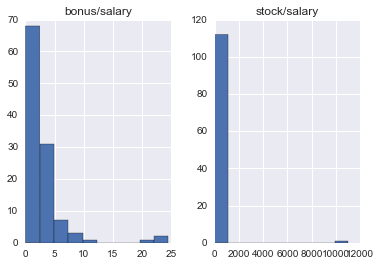

In [128]:
added_ff.hist();

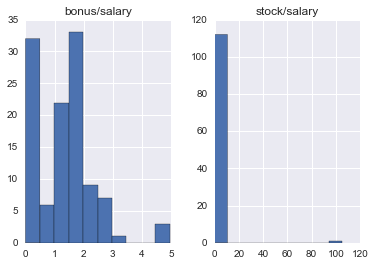

In [131]:
added_ff_sqrt.hist();

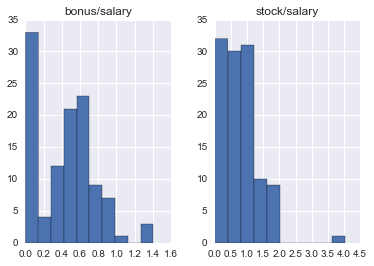

In [132]:
added_ff_log10.hist();

In [109]:
added_ff = added_ff.apply(np.sqrt)

In [106]:
added_ff.apply(np.sqrt)

,bonus_over_salary
ALLEN PHILLIP K,4.546749
BANNANTINE JAMES M,0.000000
BAXTER JOHN C,2.119591
BAY FRANKLIN R,1.291880
BAZELIDES PHILIP J,0.000000
BECK SALLY W,1.739534
BELDEN TIMOTHY N,4.953062
BERBERIAN DAVID,0.000000
BERGSIEKER RICHARD P,1.153403
BHATNAGAR SANJAY,NaN


In [98]:
added_ff.apply(math.sqrt)

TypeError: ("cannot convert the series to <type 'float'>", u'occurred at index bonus_over_salary')

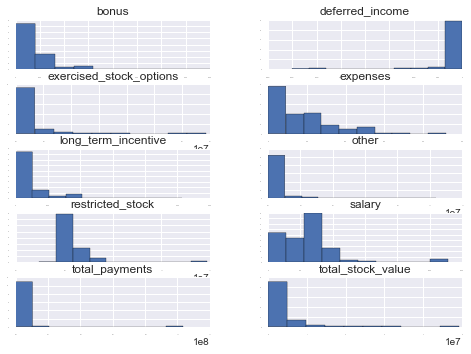

In [94]:
financial_df.hist(layout=(5,2), xlabelsize=0, ylabelsize=0);

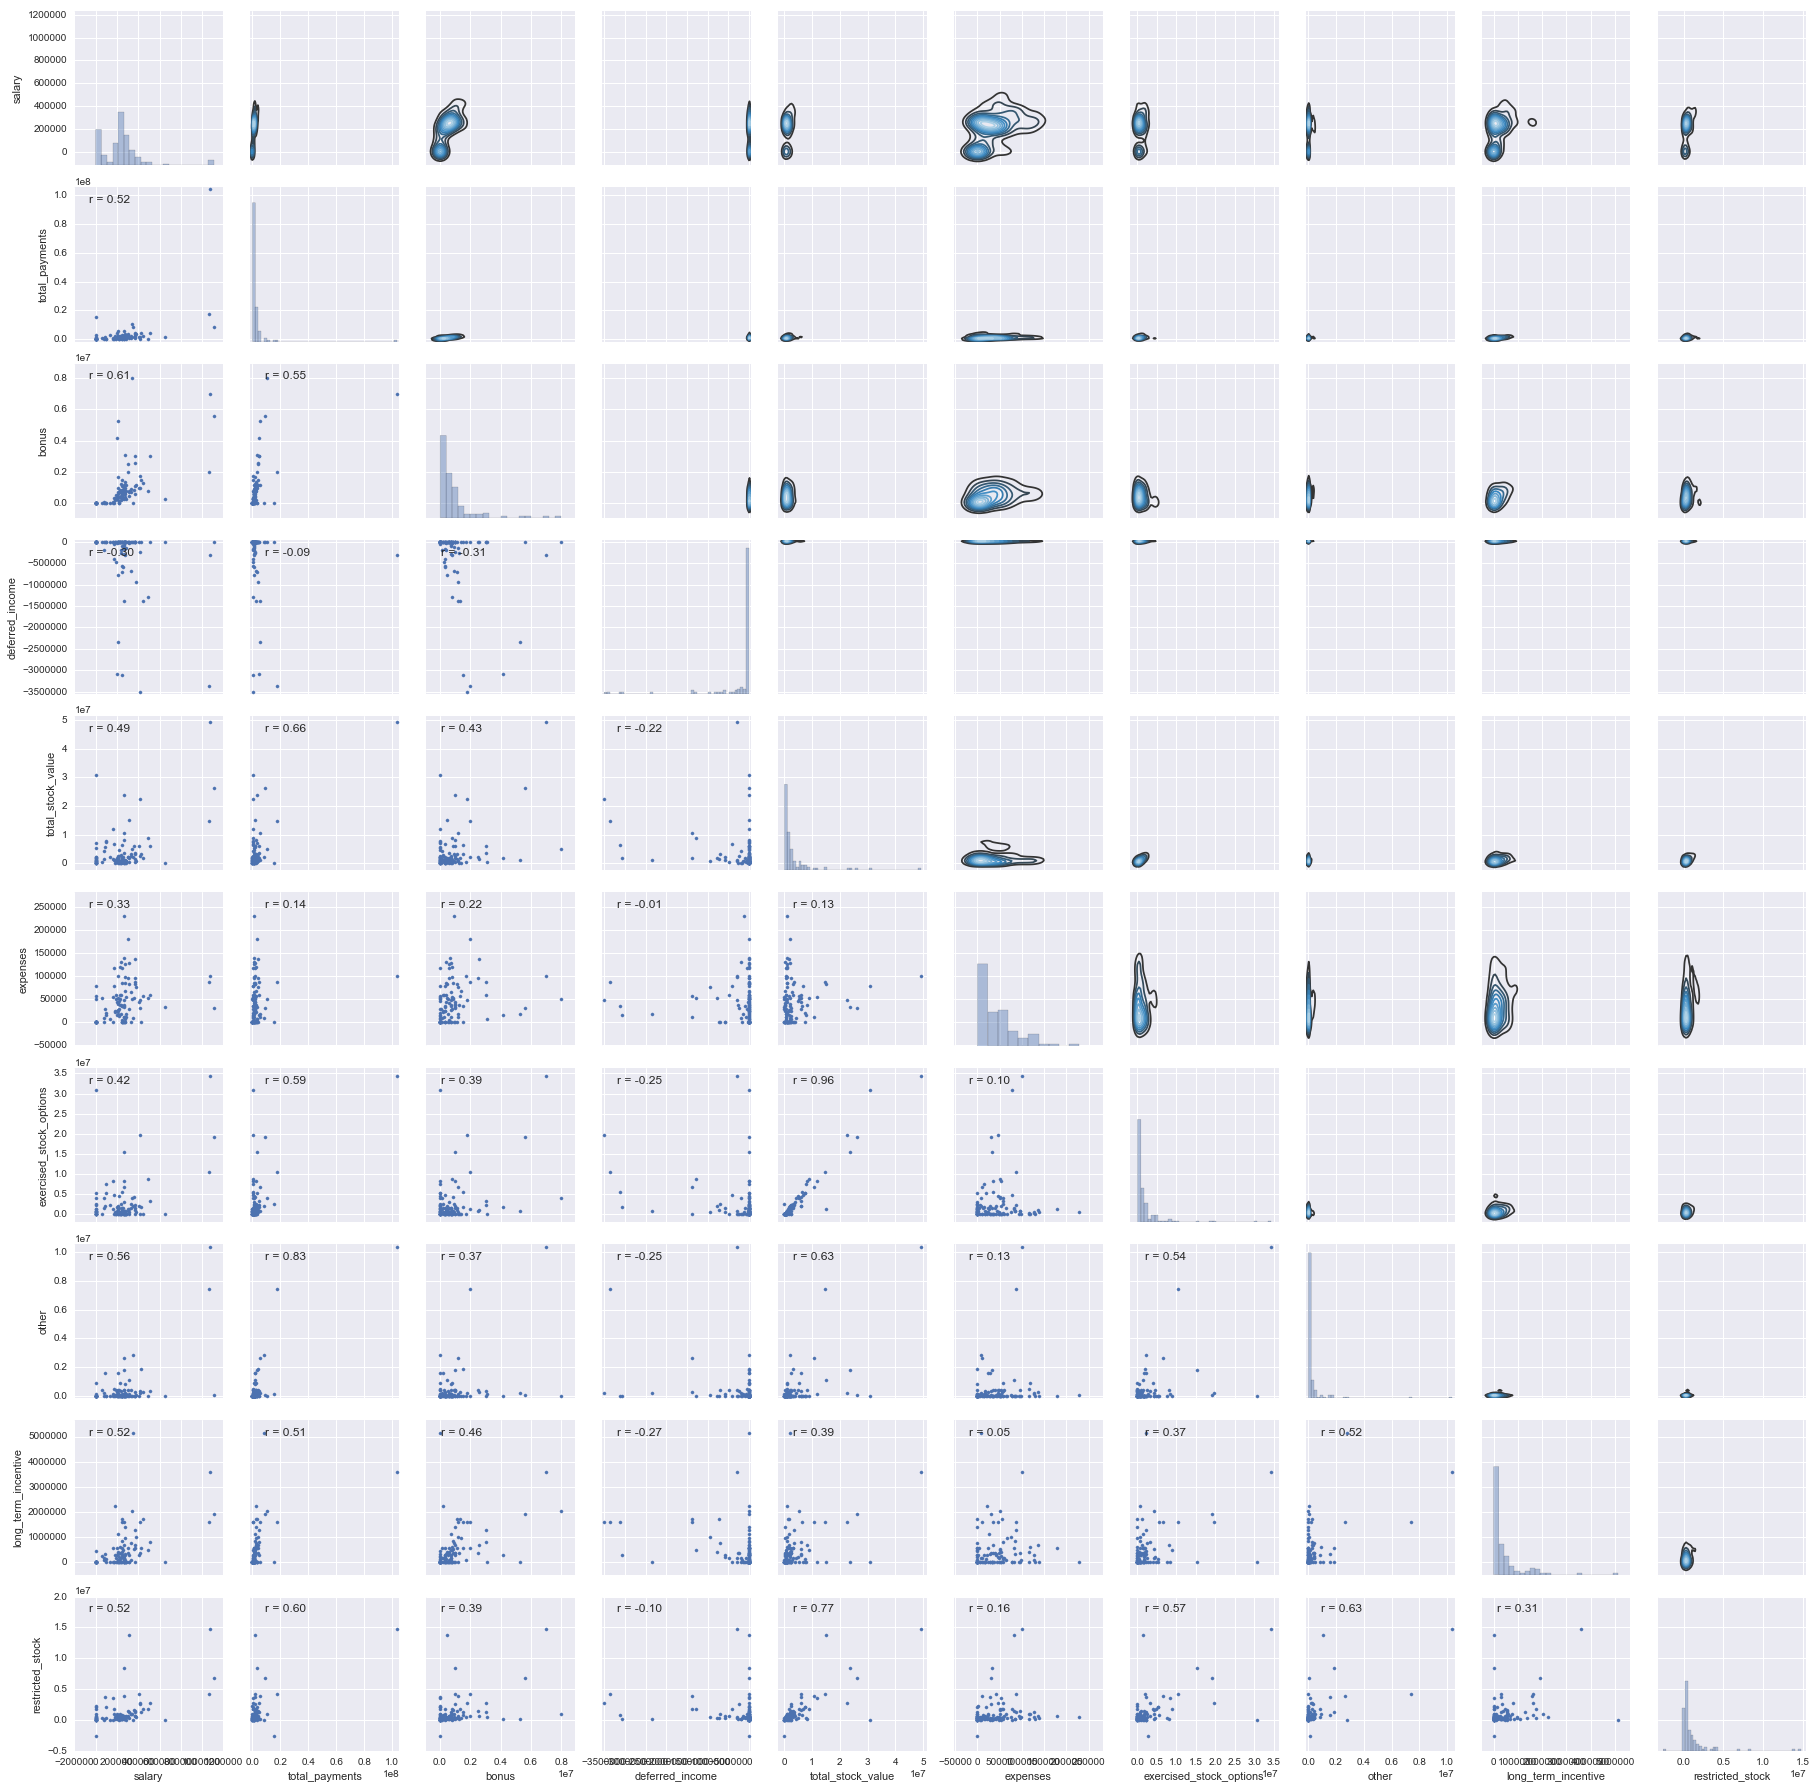

In [63]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

def pair_grid(dataframe):
    g = sns.PairGrid(dataframe, palette=["red"])
    g.map_lower(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False)
    g.map_upper(sns.kdeplot, cmap="Blues_d")
    g.map_lower(corrfunc)
    g.savefig("pairgrid.png")

sns.set()
pair_grid(financial_df)

In [11]:
#no. features remaining
features=total_features(enron_data)
#total number of data points
people=total_people(enron_data)
#allocation across classes (POI/non-POI)
poi=total_classes(enron_data)

Number of Features Available: 17
Total Number of People in the Dataset: 114
Number of POIs in the Dataset: 18 (15.79%)
Number of Non-POIs in the Dataset: 96 (84.21%)
